# **Twitter Disaster NLP**

In this notebook, we build a NLP classification model using bidirectional LSTM that predicts which Tweets are about real disasters and which one’s aren’t.

Workflow:
1. Tokenize the tweets and convert them into sequences.
2. Apply GLOVE embeddings to convert the sequences into tensors.
3. Build a bidirectional lstm model.
4. Make prediction on the test data

In [1]:
import os
import csv
import random
import zipfile

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import linregress
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# **Data Review**

In [2]:
# reading data file
TRAINING_DIR = "/kaggle/input/nlp-getting-started/train.csv"

training_data = pd.read_csv(TRAINING_DIR)

In [3]:
#Visualised data
training_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# check blank data
training_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

<AxesSubplot:title={'center':'Count of labels'}>

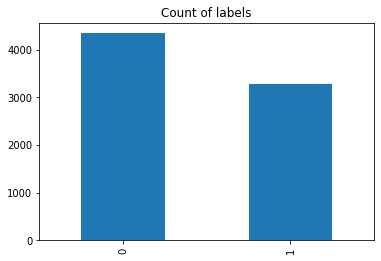

In [6]:
training_data["target"].value_counts().plot(kind='bar', title="Count of labels")

<AxesSubplot:title={'center':'Histogram of text length'}, ylabel='Frequency'>

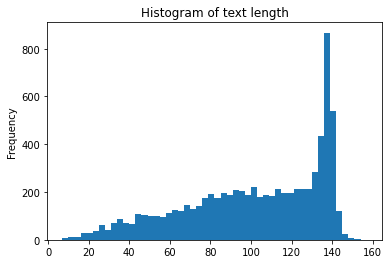

In [7]:
training_data["text"].apply(len).plot(kind='hist', bins=50, title="Histogram of text length")

# **Data Processing**

In [8]:
EMBEDDING_DIM = 100
MAXLEN = 160
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 8684
TRAINING_SPLIT = 0.9
NUM_CLASSES = 2

In [9]:
import nltk
import re, string

from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

#define preprocessing functions

def remove_stopwords(sentence):
    """
    Removes a list of stopwords
    
    Args:
        sentence (string): sentence to remove the stopwords from
    
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the numbers
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

#Replace dots with spaces
def sub_dot_with_space(text):
    text = re.sub("[.]", " ", text)
    return text

#Removing the punctuations
def remove_punctuations(text):
    text=re.sub('[%s]' % re.escape(string.punctuation), '' , text)
    return text

#Apply Lemmatization
def lemmatize(sentence):
    lemmatizer = WordNetLemmatizer()
    words = sentence.split()
    sentence = " ".join([lemmatizer.lemmatize(word) for word in words])
    return sentence

#Removing the noisy text
def pre_processing(text):
    text = strip_html(text)
    text = remove_numbers(text)
    text = sub_dot_with_space(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    return text

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


**Preprocess train data**

In [10]:
def parse_data_from_df(SENTIMENT, texts_col_name, labels_col_name):
    """
    Extracts sentences and labels from a CSV file
    
    Args:
        filename (string): path to the CSV file
    
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    
    df = pd.read_csv(SENTIMENT)

    # balance dataset
    ros = RandomOverSampler(random_state=42)
    x_balance, y_balance = ros.fit_resample(df.drop(labels_col_name, axis=1), df[labels_col_name].values)
    df = pd.concat([x_balance, pd.DataFrame(y_balance, columns= [labels_col_name])], axis=1)

    sentences = df[texts_col_name].apply(pre_processing).to_list()
      
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df[labels_col_name])
    labels = df[labels_col_name].to_list()
        
    return sentences, labels

In [11]:
sentences, labels = parse_data_from_df(TRAINING_DIR,"text","target")

print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of first example should look like this:\n{sentences[0]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of first 5 examples should look like this:\n{labels[:5]}")

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


dataset contains 8684 examples

Text of first example should look like this:
deed reason earthquake may allah forgive u

Text of fourth example should look like this:
people receive wildfire evacuation order california

Labels of first 5 examples should look like this:
[1, 1, 1, 1, 1]


**Randomize the data**

In [12]:
# Bundle the two lists into a single one
sentences_and_labels = list(zip(sentences, labels))

# Perform random sampling
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

# Unpack back into separate lists
sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 8684 sentences and 8684 labels after random sampling



In [13]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """    
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [14]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 7815 sentences for training.

There are 7815 labels for training.

There are 869 sentences for validation.

There are 869 labels for validation.


**Tokenized train data**

In [15]:
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    
    # Instantiate the Tokenizer class, passing in the correct value for oov_token
    tokenizer = Tokenizer(oov_token = oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [16]:
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print(" token included in vocabulary" if "" in word_index else " token NOT included in vocabulary")
print(f"\nindex of word 'happy' should be {word_index['happy']}")

Vocabulary contains 19013 words

 token NOT included in vocabulary

index of word 'happy' should be 901


**Add Padding**

In [17]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """        
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)

    return pad_trunc_sequences

In [18]:
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (7815, 160)

Padded and truncated validation sequences have shape: (869, 160)


In [19]:
train_labels = np.array(tf.keras.utils.to_categorical(train_labels, num_classes=NUM_CLASSES, dtype='float32'))
val_labels = np.array(tf.keras.utils.to_categorical(val_labels, num_classes=NUM_CLASSES, dtype='float32'))

print(f"training labels have shape: {train_labels.shape}\n")
print(f"validation labels have shape: {val_labels.shape}")

training labels have shape: (7815, 2)

validation labels have shape: (869, 2)


In [20]:
#download glove data for embedding
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip

--2023-02-14 03:03:43--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 54.235.118.239, 3.231.67.228, 2600:1f18:147f:e850:e203:c458:10cd:fc3c, ...
Connecting to huggingface.co (huggingface.co)|54.235.118.239|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.6B.zip%3B+filename%3D%22glove.6B.zip%22%3B&Expires=1676603024&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3N0YW5mb3JkbmxwL2dsb3ZlLzY0NzEzODJjZGQ4Mzc1NDRiZjNhYzcyNDk3YTM4NzE1ZTg0NTg5N2QyNjViMmI0MjRiNDc2MTgzMjAwOWM4Mzc%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIiwiQ29uZGl0aW9uIjp7IkRhdGVMZXNzVGhhbiI6eyJBV1M6RXBvY2hUaW1lIjoxNjc2NjAzMDI0fX19XX0_&Signature=jOBJyQ7h9hSsjQR9Us9ELAUSUAO9RxRPVm%7ElronlVRXRp3dVqlzXQMO7H6DUQLgtmg

In [21]:
#unzip glove data
with zipfile.ZipFile("/kaggle/working/glove.6B.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/working/data/")

In [22]:
os.listdir("/kaggle/working/data/")

['glove.6B.200d.txt',
 'glove.6B.300d.txt',
 'glove.6B.100d.txt',
 'glove.6B.50d.txt']

In [23]:
# Define path to file containing the embeddings
GLOVE_FILE = '/kaggle/working/data/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [24]:
# check if embeddings are implemented
test_word = 'dog'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")


Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

In [25]:
EMBEDDING_DIM = 100

# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

# **Model Building & Training**

In [26]:
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    """
    
    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings
    
    Returns:
        model (tf.keras Model): classifier model
    """
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Conv1D(filters = 64, kernel_size=6, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPool1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dropout(0.3),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax'),        
    ])
    
    optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
    #optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy']) 

    return model

In [27]:
# Create your untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

model.summary()

2023-02-14 03:05:45.663286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 03:05:45.664261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 03:05:45.833078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 03:05:45.833952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 03:05:45.834761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 160, 100)          1901400   
_________________________________________________________________
conv1d (Conv1D)              (None, 155, 64)           38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 77, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2368)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2368)              0

In [28]:
#early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                          patience=10,
                          verbose=1, 
                          restore_best_weights=True)

# Code Snippet for ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/nlp_model_balanced.h5',    
                      monitor='val_loss',    
                      save_best_only='True',    
                      verbose=1)

# Code Snippet for LearningRateScheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10 ** (epoch/2), verbose=1)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)


callbacks = [early_stopping,
        lr_scheduler,
        checkpoint,
             ]

# Train the model and save the training history
history = model.fit(train_pad_trunc_seq, train_labels, 
                    epochs=30, 
                    validation_data=(val_pad_trunc_seq, val_labels),
                    callbacks = callbacks
                    )

2023-02-14 03:05:49.902112: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-02-14 03:05:51.839394: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


245/245 [==============================] - 11s 7ms/step - loss: 0.5145 - accuracy: 0.7529 - val_loss: 0.4622 - val_accuracy: 0.7791

Epoch 00001: val_loss improved from inf to 0.46219, saving model to /content/nlp_model_balanced.h5
Epoch 2/30
245/245 [==============================] - 1s 4ms/step - loss: 0.4211 - accuracy: 0.8166 - val_loss: 0.4312 - val_accuracy: 0.8032

Epoch 00002: val_loss improved from 0.46219 to 0.43115, saving model to /content/nlp_model_balanced.h5
Epoch 3/30
245/245 [==============================] - 1s 5ms/step - loss: 0.3506 - accuracy: 0.8504 - val_loss: 0.4113 - val_accuracy: 0.8021

Epoch 00003: val_loss improved from 0.43115 to 0.41131, saving model to /content/nlp_model_balanced.h5
Epoch 4/30
245/245 [==============================] - 1s 4ms/step - loss: 0.2834 - accuracy: 0.8852 - val_loss: 0.4381 - val_accuracy: 0.8216

Epoch 00004: val_loss did not improve from 0.41131
Epoch 5/30
245/245 [==============================] - 1s 5ms/step - loss: 0.2237 -

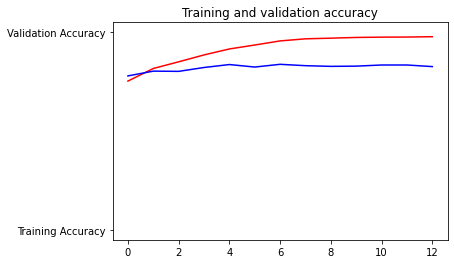

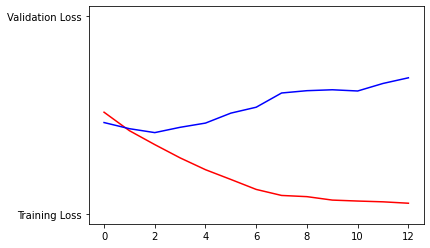

In [29]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

# **Prediction on Test data**

**Test data processing**

In [30]:
TESTING_DIR = "/kaggle/input/nlp-getting-started/test.csv"

testing_data = pd.read_csv(TESTING_DIR)

In [31]:
test_sentences = testing_data['text'].apply(pre_processing).to_list()

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [32]:
# convert sentences to sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# pad the sequences using the correct padding, truncating and maxlen
test_pad_trunc_seq = pad_sequences(test_sequences, maxlen=MAXLEN, padding=PADDING)

print(f'test_pad_trunc_seq.shape = {test_pad_trunc_seq.shape}')

test_pad_trunc_seq.shape = (3263, 160)


**Predict test data**

In [33]:
# use trained model to predict on test data 
testing_labels = model.predict(test_pad_trunc_seq)

**View prediction**

In [34]:
print(testing_labels)

[[0.05325686 0.94674313]
 [0.08187535 0.9181246 ]
 [0.21738398 0.7826161 ]
 ...
 [0.07308212 0.9269179 ]
 [0.08972444 0.9102756 ]
 [0.1398682  0.8601318 ]]


In [35]:
test = pd.read_csv(TESTING_DIR)

In [36]:
#turn categorical results into 0/1
test_labels = np.argmax(testing_labels, axis=1)

#adding the 'target' column for prediction results
test['target'] = test_labels

In [37]:
# check overall predictions
test

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [38]:
# check some disaster tweet predictions
test[test.target == 1]

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [39]:
# check some non-disaster tweet predictions
test[test.target == 0]

,id,keyword,location,text,target
6,21,NaN,NaN,They'd probably still show more life than Arse...,0
7,22,NaN,NaN,Hey! How are you?,0
8,27,NaN,NaN,What a nice hat?,0
9,29,NaN,NaN,Fuck off!,0
10,30,NaN,NaN,No I don't like cold!,0
...,...,...,...,...,...
3247,10806,wrecked,Seattle Washington,RT CNBC '3 words from Disney CEO Bob Iger wrec...,0
3248,10807,wrecked,Acey mountain islanddåÇTorontoåÈ,Smackdown tyme this should put me in a good mo...,0
3249,10816,wrecked,los angeles,@thrillhho jsyk I haven't stopped thinking abt...,0
3250,10820,wrecked,"Brussels, Belgium",@stighefootball Begovic has been garbage. He g...,0


In [40]:
# generate submission results 
submission = test[['id','target']]
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [41]:
submission.to_csv('submission_CNN.csv', index = False)